### 4.1 Conversion Models (Raw Factors)

4.1.1 Setup: Libraries, Data, and Functions

All required libraries were imported, and data preprocessing functions were defined. This step included loading the dataset and preparing functions for model training and evaluation.

4.1.2 Training and Testing Dataset Preparation

The dataset was preprocessed by addressing skewness and applying feature scaling where appropriate. To address class imbalancethe dataset was reduced by using undersampling of the negative class, which was 70% of the original data set.

4.1.3 Logistic Regression Model

A logistic regression model was developed for classification. The SHAP analysis revealed that features f6, f3 and f8 were the most influential features with mean SHAP values of 0.75, 0.6, and 0.43 respectivly.  f6 and f3 had inverse correlations, while f8 had a positive correlation.  

4.1.4 LGBM Model

A LightGBM model was trained, and SHAP analysis again identified f3, f6, and f8 as the most important features, with mean SHAP values of 0.55, 0.23, and 0.17 respectivly.  f0 was a close fourth feature, with a SHAP value of 0.15.

4.1.5 Neural Network Model

The neural network model showed consistent patternswith the other models, with f6, f3, and f8 having mean SHAP values of 0.13, 0.1, and 0.06 respectivly. f0 was close to these features with a SHAP value of 0.05, and the only other factor that had signficance in this model.

Summary

All three models had F1 scores in the mid 0.70's range.  As the data is behavioural, these values are acceptable.  It appears that f3 and f6 have negative correlations with exposure, while f8 has a positive relationship.  These values could potentially be optimized to ensure more exposure to users, or create target users, as they would be more likely to be exposed (this would depend on what the factors represent).

4.1.1 Setup:  Libraries, Data, and Functions

In [ ]:
# Install libraries
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install umap-learn
!pip install shap
!pip install optuna
!pip install xgboost
!pip install lightgbm
!pip install scipy
!pip install catboost
!pip install tensorflow

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import skew
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import optuna
import xgboost as xgb
from statistics import mode
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

In [ ]:
# Sample upload of data
# Saved from previous notebook
df_raw=pd.read_csv('raw_data.csv')

In [ ]:
# Create Stratified Sample

def get_stratified_sample_df(df, target_col, sample_frac=0.1, random_state=42):
  df_sample, _ =train_test_split(df, train_size=sample_frac, stratify=df[target_col], random_state=random_state)
  return df_sample.reset_index(drop=True)


# Create Reduced sample for unbalanced data set

def split_data_rus(df, y_colname):
    df = df.copy()
    y=df[y_colname]
    X=df.drop(y_colname,axis=1)
    X_cols=X.columns
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X, y)
    X_res=pd.DataFrame(X_res, columns=X_cols)
    y_res=pd.DataFrame(y_res, columns=[y_colname])
    df_res=pd.concat([X_res, y_res], axis=1)
    return df_res


In [ ]:
# Divide data into training and testing sets
# Correct skew on columns with skew > 0.5
# Scale factors for training and testing data sets

def split_data(df, y_colname, optional=None):
    df = df.copy()
    y = df[y_colname]
    X = df.drop(y_colname, axis=1)
    X_cols = X.columns

    # Preserve categorical columns
    cat_cols = X.select_dtypes(include='category').columns.tolist()
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Handle skew only for numeric
    skewed_cols = X_train[num_cols].apply(skew).sort_values(ascending=False)
    high_skew_cols = skewed_cols[abs(skewed_cols) > 0.5].index.tolist()

    if high_skew_cols:
      pt = PowerTransformer(method='yeo-johnson')
      X_train_skewed = pt.fit_transform(X_train[high_skew_cols])
      X_test_skewed = pt.transform(X_test[high_skew_cols])
      X_train.loc[:, high_skew_cols] = X_train_skewed
      X_test.loc[:, high_skew_cols] = X_test_skewed
    else:
      pass

    # Scale numeric only
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    optional_scaled = None
    opt_y = None
    if optional is not None:
        opt_y = optional[y_colname]
        opt_X = optional.drop(y_colname, axis=1)
        opt_X[high_skew_cols] = pt.transform(opt_X[high_skew_cols])
        opt_X[num_cols] = scaler.transform(opt_X[num_cols])
        optional_scaled = opt_X

    return X_train, X_test, y_train, y_test, optional_scaled, opt_y

In [ ]:
#  Classification Regression Tuning Model

def randomized_logreg_search(X_train, X_test, y_train, y_test, n_iter=20, cv=3, random_state=42, param_dist=None):

  if param_dist is None:
    param_dist = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced', None]
    }
  logreg = LogisticRegression(random_state=random_state)
  f1_pos=make_scorer(f1_score, pos_label=1)
  skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
  random_search = RandomizedSearchCV(
      estimator=logreg,
      param_distributions=param_dist,
      n_iter=n_iter,
      cv=skf,
      scoring=f1_pos,
      verbose=1,
      n_jobs=-1,
      random_state=random_state
  )

  random_search.fit(X_train, y_train)
  best_logreg = random_search.best_estimator_
  y_pred = best_logreg.predict(X_test)
  print("Best Parameters:", random_search.best_params_)
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(4, 3))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix (Best Logistic Regression)')
  plt.show()

  return best_logreg

In [ ]:
#  LGBM Tuning model

def randomized_lgbm_search(X_train, X_test, y_train, y_test, n_iter=20, cv=3, random_state=42, param_dist=None):

    if param_dist is None:
        param_dist = {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [3,4,5,6],
            'learning_rate': [0.05, 0.1, 0.2],
            'num_leaves': [15,31,36]
        }


    lgbm = LGBMClassifier(
        class_weight='balanced',
        random_state=random_state
    )

    f1_pos=make_scorer(f1_score, pos_label=1)
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    random_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_dist,
        n_iter=n_iter if isinstance(param_dist, dict) else 1,
        cv=skf,
        scoring=f1_pos,
        verbose=1,
        n_jobs=-1,
        random_state=random_state
    )


    random_search.fit(X_train, y_train)
    best_lgbm = random_search.best_estimator_

    # Evaluation
    y_pred = best_lgbm.predict(X_test)
    print("Best Parameters:", random_search.best_params_)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Best LightGBM)')
    plt.show()

    return best_lgbm

In [ ]:
# LGBM SHAP function

def shap_plot(model, X_train, X_test, y_train, y_test):
    # Convert categorical columns to 'category' dtype in X_test for SHAP plotting
    for col in X_train.select_dtypes(include='category').columns:
        X_test[col] = X_test[col].astype('category')

    # Fit the model
    model.fit(X_train, y_train)

    booster=model.booster_

    # Initialize the explainer directly with the model and training data
    # SHAP will handle extracting the necessary components from the LGBMClassifier object
    explainer = shap.TreeExplainer(booster)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test)

    # Determine base value and SHAP values for the positive class (class 1)
    if isinstance(shap_values, list):  # Binary classification
        shap_values_class1 = shap_values[1]
        base_value = explainer.expected_value[1]
    else: # Regression or other cases where shap_values is a single array
        shap_values_class1 = shap_values
        base_value = explainer.expected_value


    # Create SHAP explanation object
    explanation = shap.Explanation(
        values=shap_values_class1,
        base_values=np.full(shap_values_class1.shape[0], base_value),
        data=X_test,
        feature_names=X_test.columns
    )

    # Generate SHAP plots
    shap.plots.beeswarm(explanation)
    shap.plots.bar(explanation)

    mean_shap_vals= np.abs(shap_values_class1).mean(axis=0)
    top_feature = X_test.columns[np.argmax(mean_shap_vals)]
    shap.dependence_plot(top_feature, shap_values_class1, X_test)

# Regression SHAP function

def shap_plot_reg(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  explainer = shap.LinearExplainer(model, X_train, feature_peturbation='interventional')
  shap_values = explainer(X_test)

  if isinstance(shap_values,list) and len(shap_values)==2:
    shap_values_class1=shap_values[1]
  else:
    shap_values_class1 = shap_values

  shap.plots.beeswarm(shap_values)
  shap.plots.bar(shap_values)





In [ ]:
# Neural Network SHAP Function
def shap_plot_nn(model, X_train, X_test, max_samples=100, feature_names=None):
    if not isinstance(X_test, pd.DataFrame):
        if feature_names is None:
             print("Warning: feature_names not provided and X_test is not a DataFrame. SHAP plots will show numerical indices.")
             feature_names = [str(i) for i in range(X_test.shape[1])]
        X_test_df = pd.DataFrame(X_test, columns=feature_names)
    else:
        feature_names = X_test.columns.tolist()
        X_test_df = X_test

    X_sample_df = shap.sample(X_test_df, max_samples, random_state=42)
    X_sample_np = X_sample_df.values
    X_train_sample_np = shap.sample(X_train, max_samples, random_state=42).values if isinstance(X_train, pd.DataFrame) else shap.sample(X_train, max_samples, random_state=42)

    if not isinstance(X_train_sample_np, np.ndarray):
        X_train_sample_np = np.array(X_train_sample_np)

    if not isinstance(X_sample_np, np.ndarray):
         X_sample_np = np.array(X_sample_np)


    explainer = shap.DeepExplainer(model, X_train_sample_np)
    shap_values = explainer.shap_values(X_sample_np)

    if isinstance(shap_values, list) and len(shap_values) > 1:
        shap_values = shap_values[1]

    if shap_values.ndim > 2:
        if shap_values.shape[2] == 1:
             shap_values = np.squeeze(shap_values, axis=2)
        else:
             print(f"Unexpected SHAP values shape: {shap_values.shape}. Cannot reshape to 2D.")
             return
    elif shap_values.ndim == 1:

        shap_values = shap_values.reshape(-1, 1)

    shap.plots.beeswarm(shap.Explanation(values=shap_values, data=X_sample_np, feature_names=feature_names))
    shap.plots.bar(shap.Explanation(values=shap_values, data=X_sample_np, feature_names=feature_names))

4.1.2 Create Training and Testing Datasets

In [ ]:
# Remove unnecessary columns, reduce sample size

df=df_raw.copy()
df=df[df['treatment']==1].reset_index(drop=True)
df=df.drop(['treatment','conversion'], axis=1)
sample=split_data_rus(df, 'exposure')
sample=get_stratified_sample_df(sample, 'exposure', sample_frac=0.1)
sample.shape

(35295, 13)

In [ ]:
# Correct skew, split data, scale data

X_train, X_test, y_train, y_test, optional_scaled, opt_y=split_data(sample,'exposure')

4.1.3  Classification Regression Model

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced', 'C': 0.1}

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      3529
           1       0.77      0.73      0.75      3530

    accuracy                           0.75      7059
   macro avg       0.76      0.75      0.75      7059
weighted avg       0.76      0.75      0.75      7059



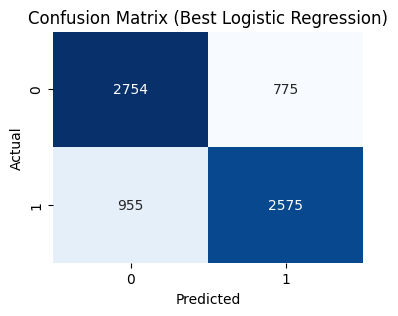

In [ ]:
# Create tuned regression model
best_logreg_all=randomized_logreg_search(X_train, X_test, y_train, y_test, n_iter=20, cv=3, random_state=42)

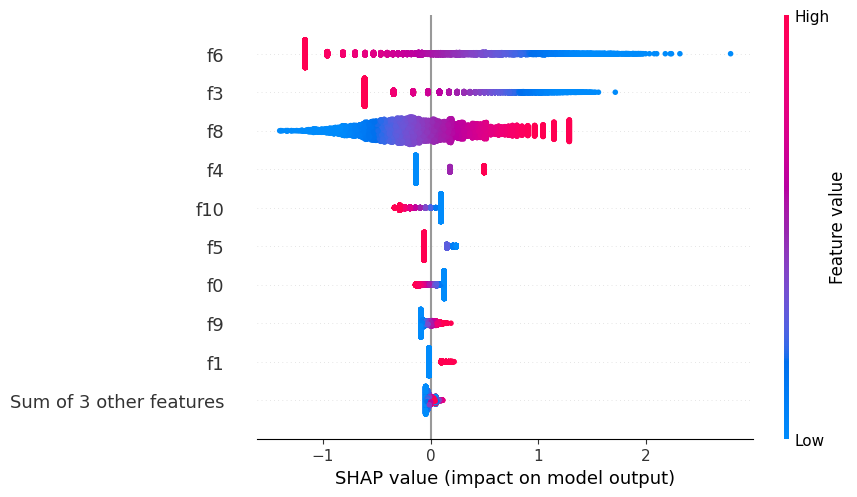

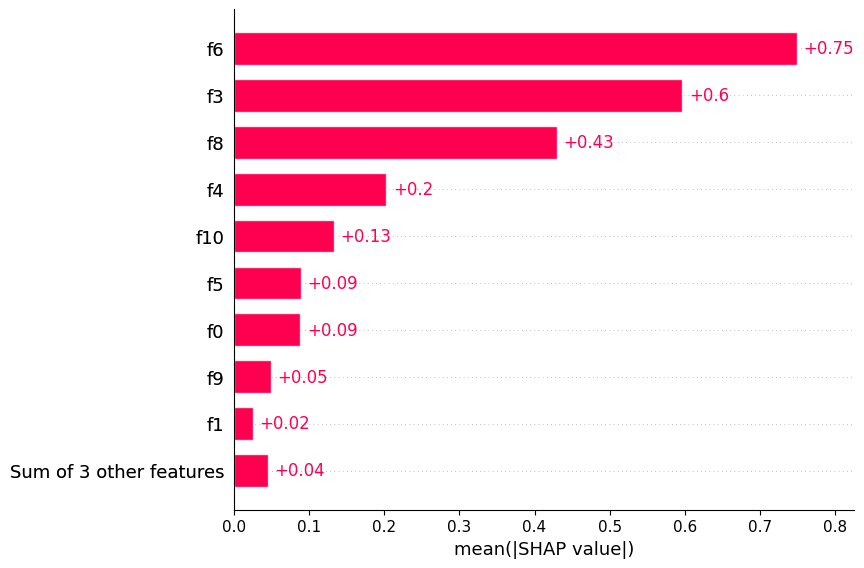

In [ ]:
# SHAP plots for regression model
shap_plot_reg(best_logreg_all, X_train, X_test, y_train, y_test)

Regression Conclusions:

The F1 score for the model was 0.75, and accuracy was also 0.75, which is acceptable for this type of model, as the factors include behavioural data.

f6, f3, and f8 had the greatest impact on exposure, with f6 and f3 having an inverse relationship with exposure, and f8 having a positive relationship.  These factors had far more influence than the other factors in terms of the their mean SHAP values.


4.1.4 LGBM Model

In [ ]:
# Determine parameter range for LGBM model

def objective(trial):
    # Hyperparameter suggestions
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_categorical('max_depth', [-1, 3, 5, 7, 10, 15])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 100)
    min_split_gain = trial.suggest_float('min_split_gain', 0.0, 0.2)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)

    # Constraint 1: num_leaves should not greatly exceed 2^max_depth
    if max_depth > 0:
        max_allowed_leaves = 2 ** max_depth
        if num_leaves > max_allowed_leaves:
            raise optuna.exceptions.TrialPruned()

    # Constraint 2: Avoid too many estimators with low learning rate
    if learning_rate < 0.01 and n_estimators > 600:
        raise optuna.exceptions.TrialPruned()

    # Get categorical column names
    cat_cols = X_train.select_dtypes(include='category').columns.tolist()

    # Define model
    model = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        min_split_gain=min_split_gain,
        random_state=42,
        #class_weight='balanced'

    )

    # Use F1 for positive class
    f1_pos = make_scorer(f1_score, pos_label=1)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Cross-validation
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=skf,
        scoring=f1_pos,
        return_train_score=False
    )

    return scores['test_score'].mean()

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters
best_params_lgbm = study.best_params

[I 2025-05-20 18:15:37,796] A new study created in memory with name: no-name-5216bf20-a3a1-49df-bc75-838e71394292


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-20 18:15:50,221] Trial 0 finished with value: 0.7329087305079586 and parameters: {'n_estimators': 747, 'max_depth': 10, 'learning_rate': 0.14436241753496842, 'subsample': 0.7373458100733965, 'colsample_bytree': 0.7109572361243488, 'num_leaves': 68, 'min_child_samples': 57, 'min_split_gain': 0.004645164846757233, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.7329087305079586.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:16:04,828] Trial 1 finished with value: 0.7614610158859382 and parameters: {'n_estimators': 900, 'max_depth': 15, 'learning_rate': 0.01123237805472732, 'subsample': 0.7718267520550435, 'colsample_bytree': 0.7690732388977839, 'num_leaves': 51, 'min_child_samples': 50, 'min_split_gain': 0.09514885247688572, 'scale_pos_weight': 4}. Best is trial 1 with value: 0.7614610158859382.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:16:14,111] Trial 2 finished with value: 0.7580062711484074 and parameters: {'n_estimators': 406, 'max_depth': 15, 'learning_rate': 0.02113279596459163, 'subsample': 0.766856244822473, 'colsample_bytree': 0.7171790591444196, 'num_leaves': 103, 'min_child_samples': 49, 'min_split_gain': 0.15932664146131545, 'scale_pos_weight': 4}. Best is trial 1 with value: 0.7614610158859382.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:16:15,653] Trial 3 finished with value: 0.7664926615965548 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.04997695291697363, 'subsample': 0.608008839577448, 'colsample_bytree': 0.7699926420782599, 'num_leaves': 23, 'min_child_samples': 44, 'min_split_gain': 0.013313585566796383, 'scale_pos_weight': 3}. Best is trial 3 with value: 0.7664926615965548.
[I 2025-05-20 18:16:15,658] Trial 4 pruned. 
[I 2025-05-20 18:16:15,662] Trial 5 pruned. 


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:16:32,241] Trial 6 finished with value: 0.7612605349218414 and parameters: {'n_estimators': 887, 'max_depth': 15, 'learning_rate': 0.011978232991292326, 'subsample': 0.517797036704388, 'colsample_bytree': 0.7180489468906661, 'num_leaves': 76, 'min_child_samples': 19, 'min_split_gain': 0.1400966762327764, 'scale_pos_weight': 8}. Best is trial 3 with value: 0.7664926615965548.


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there ar

[I 2025-05-20 18:16:35,686] Trial 7 finished with value: 0.7574612538246196 and parameters: {'n_estimators': 893, 'max_depth': 10, 'learning_rate': 0.1757686812075954, 'subsample': 0.8414379069043504, 'colsample_bytree': 0.8997088424914261, 'num_leaves': 65, 'min_child_samples': 61, 'min_split_gain': 0.19591446011292485, 'scale_pos_weight': 2}. Best is trial 3 with value: 0.7664926615965548.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

[I 2025-05-20 18:16:44,235] Trial 8 finished with value: 0.7648243650943815 and parameters: {'n_estimators': 362, 'max_depth': 10, 'learning_rate': 0.0014060805726820041, 'subsample': 0.5346614421023757, 'colsample_bytree': 0.7476108583523216, 'num_leaves': 115, 'min_child_samples': 81, 'min_split_gain': 0.11016787739355988, 'scale_pos_weight': 7}. Best is trial 3 with value: 0.7664926615965548.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:16:55,399] Trial 9 finished with value: 0.763597126822232 and parameters: {'n_estimators': 613, 'max_depth': 15, 'learning_rate': 0.01085593394039557, 'subsample': 0.5837294811987543, 'colsample_bytree': 0.6595303565388612, 'num_leaves': 58, 'min_child_samples': 78, 'min_split_gain': 0.013343313704381044, 'scale_pos_weight': 3}. Best is trial 3 with value: 0.7664926615965548.
[I 2025-05-20 18:16:55,449] Trial 10 pruned. 


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

[I 2025-05-20 18:16:56,663] Trial 11 finished with value: 0.7646436374242896 and parameters: {'n_estimators': 51, 'max_depth': -1, 'learning_rate': 0.0012704149033640302, 'subsample': 0.5061116467266075, 'colsample_bytree': 0.8283332855756361, 'num_leaves': 112, 'min_child_samples': 77, 'min_split_gain': 0.05573389535304655, 'scale_pos_weight': 6}. Best is trial 3 with value: 0.7664926615965548.
[I 2025-05-20 18:16:56,722] Trial 12 pruned. 
[I 2025-05-20 18:16:56,769] Trial 13 pruned. 
[I 2025-05-20 18:16:56,819] Trial 14 pruned. 


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative

[I 2025-05-20 18:17:03,149] Trial 15 finished with value: 0.7630253760421163 and parameters: {'n_estimators': 588, 'max_depth': 10, 'learning_rate': 0.0010374275709498062, 'subsample': 0.5666335840060577, 'colsample_bytree': 0.9606412586678346, 'num_leaves': 22, 'min_child_samples': 34, 'min_split_gain': 0.08329458954248517, 'scale_pos_weight': 5}. Best is trial 3 with value: 0.7664926615965548.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

[I 2025-05-20 18:17:06,261] Trial 16 finished with value: 0.7583971997321263 and parameters: {'n_estimators': 126, 'max_depth': -1, 'learning_rate': 0.05479005482895325, 'subsample': 0.7092752309841782, 'colsample_bytree': 0.8009496297074287, 'num_leaves': 91, 'min_child_samples': 89, 'min_split_gain': 0.1661955906584155, 'scale_pos_weight': 1}. Best is trial 3 with value: 0.7664926615965548.
[I 2025-05-20 18:17:06,344] Trial 17 pruned. 


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-20 18:17:12,453] Trial 18 finished with value: 0.7497214973621982 and parameters: {'n_estimators': 343, 'max_depth': 10, 'learning_rate': 0.09452515932786609, 'subsample': 0.8882316294270658, 'colsample_bytree': 0.992292907912647, 'num_leaves': 82, 'min_child_samples': 43, 'min_split_gain': 0.031493033318509125, 'scale_pos_weight': 8}. Best is trial 3 with value: 0.7664926615965548.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 18824, number of used feat

[I 2025-05-20 18:17:17,934] Trial 19 finished with value: 0.7661757813250416 and parameters: {'n_estimators': 551, 'max_depth': 5, 'learning_rate': 0.005640277197467626, 'subsample': 0.67360017261166, 'colsample_bytree': 0.6367955820536644, 'num_leaves': 20, 'min_child_samples': 84, 'min_split_gain': 0.07373611702268848, 'scale_pos_weight': 5}. Best is trial 3 with value: 0.7664926615965548.
[I 2025-05-20 18:17:18,017] Trial 20 pruned. 
[I 2025-05-20 18:17:18,072] Trial 21 pruned. 


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:17:25,218] Trial 22 finished with value: 0.7644846382685483 and parameters: {'n_estimators': 513, 'max_depth': 5, 'learning_rate': 0.0017657466331031228, 'subsample': 0.5527847258809357, 'colsample_bytree': 0.7610769772033679, 'num_leaves': 31, 'min_child_samples': 63, 'min_split_gain': 0.03394268849566301, 'scale_pos_weight': 7}. Best is trial 3 with value: 0.7664926615965548.
[I 2025-05-20 18:17:25,277] Trial 23 pruned. 


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative

[I 2025-05-20 18:17:28,497] Trial 24 finished with value: 0.7668070598405977 and parameters: {'n_estimators': 161, 'max_depth': 10, 'learning_rate': 0.0037066041108012736, 'subsample': 0.6617087788445083, 'colsample_bytree': 0.6743981532133291, 'num_leaves': 105, 'min_child_samples': 66, 'min_split_gain': 0.12183569383537611, 'scale_pos_weight': 2}. Best is trial 24 with value: 0.7668070598405977.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

[I 2025-05-20 18:17:30,385] Trial 25 finished with value: 0.7647204326258578 and parameters: {'n_estimators': 163, 'max_depth': 5, 'learning_rate': 0.003603007083851062, 'subsample': 0.8090683062139116, 'colsample_bytree': 0.6709363462548636, 'num_leaves': 25, 'min_child_samples': 67, 'min_split_gain': 0.016672113408208993, 'scale_pos_weight': 2}. Best is trial 24 with value: 0.7668070598405977.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:17:31,485] Trial 26 finished with value: 0.7673409769376662 and parameters: {'n_estimators': 53, 'max_depth': 7, 'learning_rate': 0.02345268130106721, 'subsample': 0.6686873682575911, 'colsample_bytree': 0.5979301271315969, 'num_leaves': 105, 'min_child_samples': 44, 'min_split_gain': 0.13905760183969926, 'scale_pos_weight': 2}. Best is trial 26 with value: 0.7673409769376662.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-20 18:17:32,703] Trial 27 finished with value: 0.7674684283625456 and parameters: {'n_estimators': 58, 'max_depth': 7, 'learning_rate': 0.02145601389425853, 'subsample': 0.7243642734248392, 'colsample_bytree': 0.547754254217367, 'num_leaves': 102, 'min_child_samples': 44, 'min_split_gain': 0.1327390538669074, 'scale_pos_weight': 2}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:17:33,897] Trial 28 finished with value: 0.7666163662877868 and parameters: {'n_estimators': 51, 'max_depth': 7, 'learning_rate': 0.018993236029615838, 'subsample': 0.7307880978114265, 'colsample_bytree': 0.5552603157216455, 'num_leaves': 104, 'min_child_samples': 29, 'min_split_gain': 0.13465561500775985, 'scale_pos_weight': 2}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-20 18:17:36,129] Trial 29 finished with value: 0.7667414332067134 and parameters: {'n_estimators': 87, 'max_depth': 7, 'learning_rate': 0.027018785422004456, 'subsample': 0.7269359048107666, 'colsample_bytree': 0.5542436282124871, 'num_leaves': 102, 'min_child_samples': 53, 'min_split_gain': 0.16158031328724964, 'scale_pos_weight': 1}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:17:39,900] Trial 30 finished with value: 0.7664537647380114 and parameters: {'n_estimators': 201, 'max_depth': 7, 'learning_rate': 0.0137415995988242, 'subsample': 0.8042293092737002, 'colsample_bytree': 0.6041839315254649, 'num_leaves': 126, 'min_child_samples': 59, 'min_split_gain': 0.1844463212341001, 'scale_pos_weight': 1}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:17:41,490] Trial 31 finished with value: 0.7674666008381291 and parameters: {'n_estimators': 91, 'max_depth': 7, 'learning_rate': 0.02813780041393422, 'subsample': 0.728713805740283, 'colsample_bytree': 0.5489676847721452, 'num_leaves': 101, 'min_child_samples': 53, 'min_split_gain': 0.15821542597199537, 'scale_pos_weight': 1}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-20 18:17:45,381] Trial 32 finished with value: 0.7629748056788648 and parameters: {'n_estimators': 274, 'max_depth': 7, 'learning_rate': 0.04448843705085531, 'subsample': 0.7516423612107755, 'colsample_bytree': 0.5362605019813639, 'num_leaves': 93, 'min_child_samples': 45, 'min_split_gain': 0.15036954331069718, 'scale_pos_weight': 2}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:17:46,984] Trial 33 finished with value: 0.7671636771931988 and parameters: {'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.00821955562468496, 'subsample': 0.7885472892541102, 'colsample_bytree': 0.5821225576861886, 'num_leaves': 110, 'min_child_samples': 55, 'min_split_gain': 0.12523982963646804, 'scale_pos_weight': 1}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:17:48,909] Trial 34 finished with value: 0.7674440103926589 and parameters: {'n_estimators': 92, 'max_depth': 7, 'learning_rate': 0.009675886665063204, 'subsample': 0.7840378436873301, 'colsample_bytree': 0.5877954916185775, 'num_leaves': 82, 'min_child_samples': 53, 'min_split_gain': 0.17268785386966837, 'scale_pos_weight': 1}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:17:51,619] Trial 35 finished with value: 0.7659438643218209 and parameters: {'n_estimators': 117, 'max_depth': 7, 'learning_rate': 0.02487283929510267, 'subsample': 0.8685664758515564, 'colsample_bytree': 0.5274396484804634, 'num_leaves': 78, 'min_child_samples': 49, 'min_split_gain': 0.17649580907582604, 'scale_pos_weight': 1}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:17:55,071] Trial 36 finished with value: 0.7656555872486329 and parameters: {'n_estimators': 213, 'max_depth': 7, 'learning_rate': 0.01646714802362451, 'subsample': 0.7646107049081673, 'colsample_bytree': 0.5881840319596444, 'num_leaves': 72, 'min_child_samples': 41, 'min_split_gain': 0.1485041145578111, 'scale_pos_weight': 2}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:17:59,683] Trial 37 finished with value: 0.76536674255288 and parameters: {'n_estimators': 277, 'max_depth': 7, 'learning_rate': 0.009222833773601164, 'subsample': 0.8306312910060116, 'colsample_bytree': 0.6981100068117606, 'num_leaves': 85, 'min_child_samples': 52, 'min_split_gain': 0.1747019424814753, 'scale_pos_weight': 4}. Best is trial 27 with value: 0.7674684283625456.
[I 2025-05-20 18:17:59,739] Trial 38 pruned. 


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:18:12,895] Trial 39 finished with value: 0.7616829042645089 and parameters: {'n_estimators': 959, 'max_depth': 7, 'learning_rate': 0.017743284866297587, 'subsample': 0.7447139415455228, 'colsample_bytree': 0.5428897727001987, 'num_leaves': 99, 'min_child_samples': 41, 'min_split_gain': 0.15235839507744817, 'scale_pos_weight': 1}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:18:14,028] Trial 40 finished with value: 0.7670135219284187 and parameters: {'n_estimators': 53, 'max_depth': 7, 'learning_rate': 0.02503664692407731, 'subsample': 0.7785456201259066, 'colsample_bytree': 0.6318697649723166, 'num_leaves': 89, 'min_child_samples': 31, 'min_split_gain': 0.10266468369615173, 'scale_pos_weight': 3}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:18:15,864] Trial 41 finished with value: 0.7670293086128236 and parameters: {'n_estimators': 103, 'max_depth': 7, 'learning_rate': 0.007506593555136053, 'subsample': 0.7933465386711234, 'colsample_bytree': 0.5824984143361451, 'num_leaves': 116, 'min_child_samples': 55, 'min_split_gain': 0.12598064101892695, 'scale_pos_weight': 1}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-20 18:18:17,988] Trial 42 finished with value: 0.7673410661544802 and parameters: {'n_estimators': 92, 'max_depth': 7, 'learning_rate': 0.009744202014329986, 'subsample': 0.9071816192093773, 'colsample_bytree': 0.5817731240876316, 'num_leaves': 109, 'min_child_samples': 58, 'min_split_gain': 0.14281318799872847, 'scale_pos_weight': 1}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative

[I 2025-05-20 18:18:21,261] Trial 43 finished with value: 0.7655642997682442 and parameters: {'n_estimators': 145, 'max_depth': 15, 'learning_rate': 0.01413714928731457, 'subsample': 0.9477890808091765, 'colsample_bytree': 0.5225505804969021, 'num_leaves': 67, 'min_child_samples': 39, 'min_split_gain': 0.1424163235526339, 'scale_pos_weight': 2}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:18:26,159] Trial 44 finished with value: 0.7661838352897495 and parameters: {'n_estimators': 310, 'max_depth': 7, 'learning_rate': 0.010508500474192868, 'subsample': 0.9333948591367955, 'colsample_bytree': 0.5755799026802538, 'num_leaves': 119, 'min_child_samples': 59, 'min_split_gain': 0.1857942582378416, 'scale_pos_weight': 4}. Best is trial 27 with value: 0.7674684283625456.
[I 2025-05-20 18:18:26,225] Trial 45 pruned. 


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:18:30,029] Trial 46 finished with value: 0.7531370923022657 and parameters: {'n_estimators': 184, 'max_depth': -1, 'learning_rate': 0.06656381882420137, 'subsample': 0.8724462664186619, 'colsample_bytree': 0.59773338823561, 'num_leaves': 131, 'min_child_samples': 57, 'min_split_gain': 0.13245116295779907, 'scale_pos_weight': 1}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-20 18:18:41,684] Trial 47 finished with value: 0.7623273441251448 and parameters: {'n_estimators': 766, 'max_depth': 7, 'learning_rate': 0.0204100660760881, 'subsample': 0.9165115175089639, 'colsample_bytree': 0.5092324906430681, 'num_leaves': 79, 'min_child_samples': 73, 'min_split_gain': 0.1568107418351883, 'scale_pos_weight': 2}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-20 18:18:45,419] Trial 48 finished with value: 0.7657693642625091 and parameters: {'n_estimators': 247, 'max_depth': 7, 'learning_rate': 0.013806892091525257, 'subsample': 0.7123461615455347, 'colsample_bytree': 0.7300851442787475, 'num_leaves': 59, 'min_child_samples': 63, 'min_split_gain': 0.1453409826811945, 'scale_pos_weight': 3}. Best is trial 27 with value: 0.7674684283625456.


[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative: 9412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 18824, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9412, number of negative

[I 2025-05-20 18:18:47,578] Trial 49 finished with value: 0.764787984484515 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.026556545972655356, 'subsample': 0.8350587718169833, 'colsample_bytree': 0.5546779102245748, 'num_leaves': 99, 'min_child_samples': 24, 'min_split_gain': 0.17612756958856843, 'scale_pos_weight': 1}. Best is trial 27 with value: 0.7674684283625456.


In [ ]:
best_params_lgbm

{'n_estimators': 58,
 'max_depth': 7,
 'learning_rate': 0.02145601389425853,
 'subsample': 0.7243642734248392,
 'colsample_bytree': 0.547754254217367,
 'num_leaves': 102,
 'min_child_samples': 44,
 'min_split_gain': 0.1327390538669074,
 'scale_pos_weight': 2}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 14118, number of negative: 14118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 28236, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Parameters: {'scale_pos_weight': 2, 'num_leaves': 102, 'n_estimators': 58, 'max_depth': 7, 'learning_rate': 0.02}

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.58      0.69      3529
           1       0.68      0.89      0.77      3530

    accuracy                           0.74      7059
   macro avg       0.76      0.74      0.73      7059
weighted avg       0.76      0.74      0.73      7059



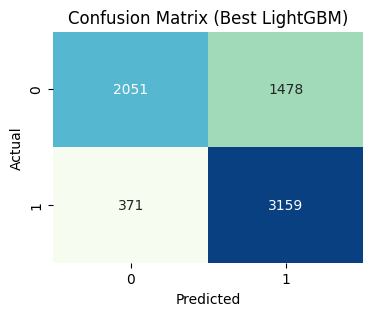

In [ ]:
# Use best parameters to create lgbm model
param_dist = {
            'n_estimators': [58],
            'max_depth': [7],
            'learning_rate': [.02],
            'num_leaves': [102],
            'scale_pos_weight': [2]
        }

best_lgbm=randomized_lgbm_search(X_train, X_test, y_train, y_test, n_iter=20, cv=3, random_state=42, param_dist=param_dist)


[LightGBM] [Info] Number of positive: 14118, number of negative: 14118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 28236, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


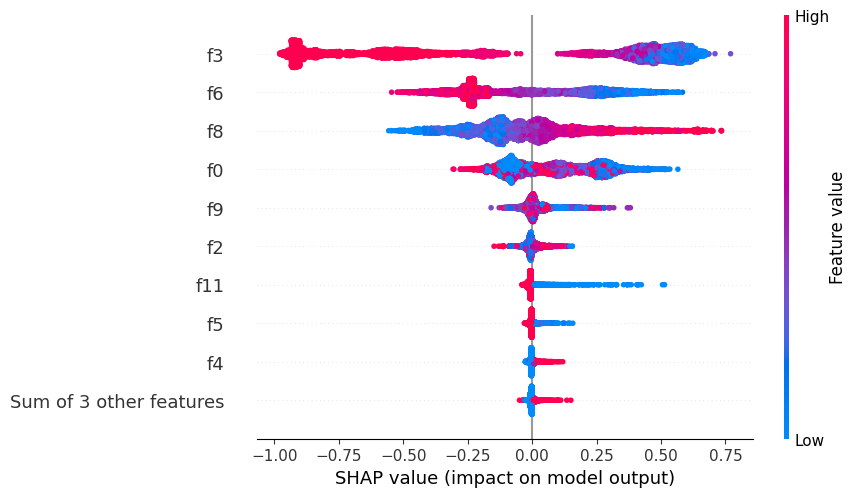

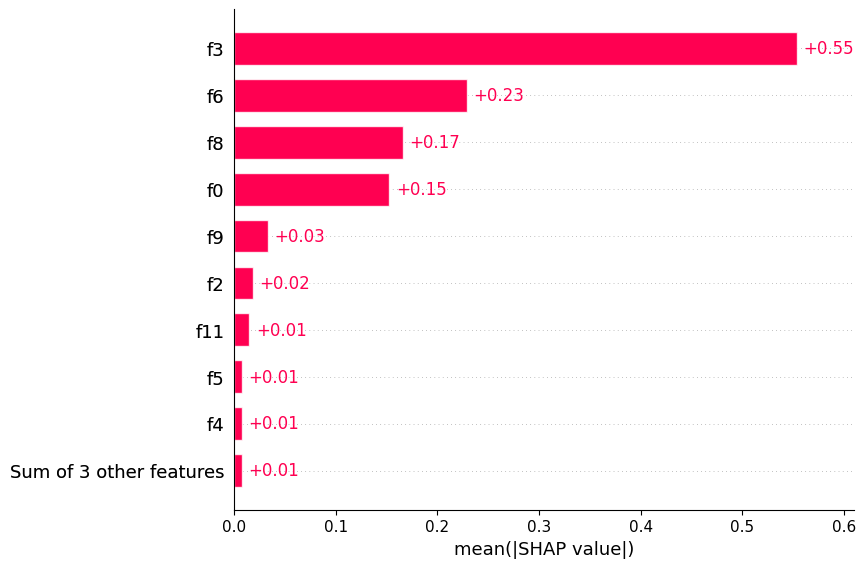

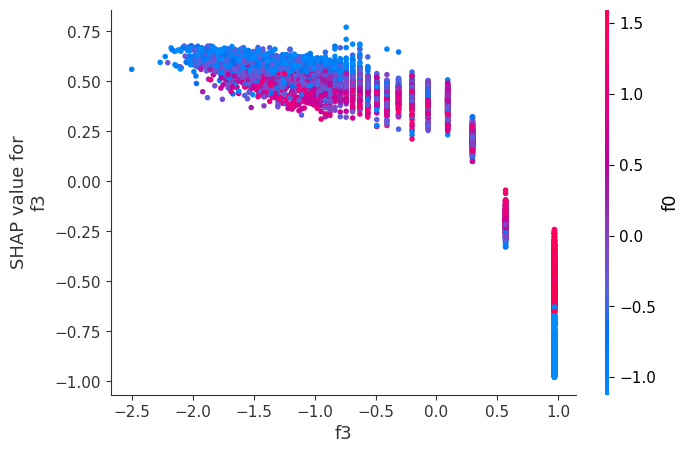

In [ ]:
# Create SHAP plots for lgbm model
shap_plot(best_lgbm, X_train, X_test, y_train, y_test)

LGBM Conclusions:

The F1 score for the model was 0.77, and accuracy was also 0.74, which is acceptable for this type of model, as the factors include behavioural data.

f3, f6, and f8 were the top three factors impacting exposure in the lgbm model in the same way found in the regression model.  We see that negative values of f3 have a similar and small impact on the SHAP value, while positive values appear to have a greater impact on the shap value in the negative direction.  f0 values appaer to have a quadratic relationship with exposure.


4.1.5 Neural Network Model

As results are similar for linear and gradient boosted models, a neural network model will be used to determine if it is able to increase the f1 scores for the model.

In [ ]:
#  Tune neural network parameters
def create_model(trial, input_dim):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    # Tune number of hidden layers
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        units = trial.suggest_int(f'units_{i}', 32, 128, step=32)
        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.2, 0.5)
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))

    # Tune learning rate
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy')
    return model

In [ ]:
from tensorflow.keras import backend as K
def objective(trial):
    f1_scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = create_model(trial, X_tr.shape[1])

        # Handle class imbalance
        class_weight = {0: 1.0, 1: len(y_tr[y_tr == 0]) / len(y_tr[y_tr == 1])}

        model.fit(X_tr, y_tr,
                  epochs=20,
                  batch_size=32,
                  verbose=0,
                  class_weight=class_weight)

        y_pred = model.predict(X_val).ravel()
        y_pred_binary = (y_pred > 0.5).astype(int)
        f1 = f1_score(y_val, y_pred_binary, pos_label=1)
        f1_scores.append(f1)

        # Clear session to avoid memory buildup
        K.clear_session()

    return np.mean(f1_scores)

In [ ]:
from tensorflow.keras import backend as K
def objective(trial):
    f1_scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = create_model(trial, X_tr.shape[1])

        # Handle class imbalance
        class_weight = {0: 1.0, 1: len(y_tr[y_tr == 0]) / len(y_tr[y_tr == 1])}

        model.fit(X_tr, y_tr,
                  epochs=20,
                  batch_size=32,
                  verbose=0,
                  class_weight=class_weight)

        y_pred = model.predict(X_val).ravel()
        y_pred_binary = (y_pred > 0.5).astype(int)
        f1 = f1_score(y_val, y_pred_binary, pos_label=1)
        f1_scores.append(f1)

        # Clear session to avoid memory buildup
        K.clear_session()

    return np.mean(f1_scores)

In [ ]:
print("Best trial:")
print(f"Value: {study.best_value}")
print("Params:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Best trial:
Value: 0.7683501372174993
Params:
  n_layers: 1
  units_0: 96
  dropout_0: 0.3013483624844905
  learning_rate: 0.006102930548568351


In [ ]:
# Use tuned parameters in neural network model

class_weight = {0: 1.0, 1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])}
final_model = create_model(study.best_trial, X_train.shape[1])

final_model.fit(X_train, y_train,
                epochs=20,
                batch_size=32,
                class_weight=class_weight,
                verbose=1)

# Evaluate on test set
y_pred_test = (final_model.predict(X_test) > 0.5).astype("int32")
print("\nFinal F1 Score (positive class):", f1_score(y_test, y_pred_test, pos_label=1))

Epoch 1/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5198
Epoch 2/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4971
Epoch 3/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5018
Epoch 4/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5039
Epoch 5/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4995
Epoch 6/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5008
Epoch 7/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4977
Epoch 8/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4955
Epoch 9/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4908
Epoch 10/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5014
Epoch 11/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4953
Epoch 12/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4969
Epoch 13/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4965
Epoch 14/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4992
Epoch 15/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lo


NN Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      3529
           1       0.76      0.77      0.76      3530

    accuracy                           0.76      7059
   macro avg       0.76      0.76      0.76      7059
weighted avg       0.76      0.76      0.76      7059



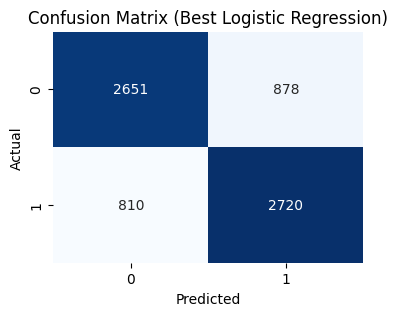

In [ ]:
  print("\nNN Classification Report:")
  print(classification_report(y_test, y_pred_test))

  cm = confusion_matrix(y_test, y_pred_test)
  plt.figure(figsize=(4, 3))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix (Best Logistic Regression)')
  plt.show()

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 12))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 12))']
  warnings.warn(msg)


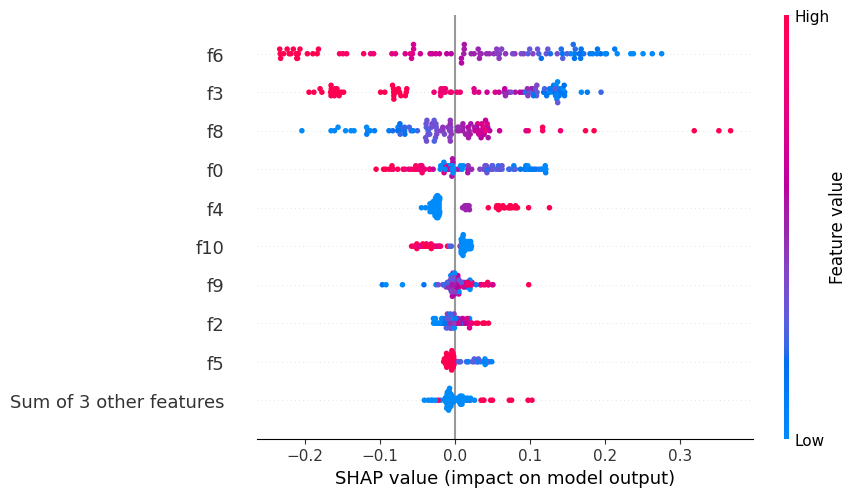

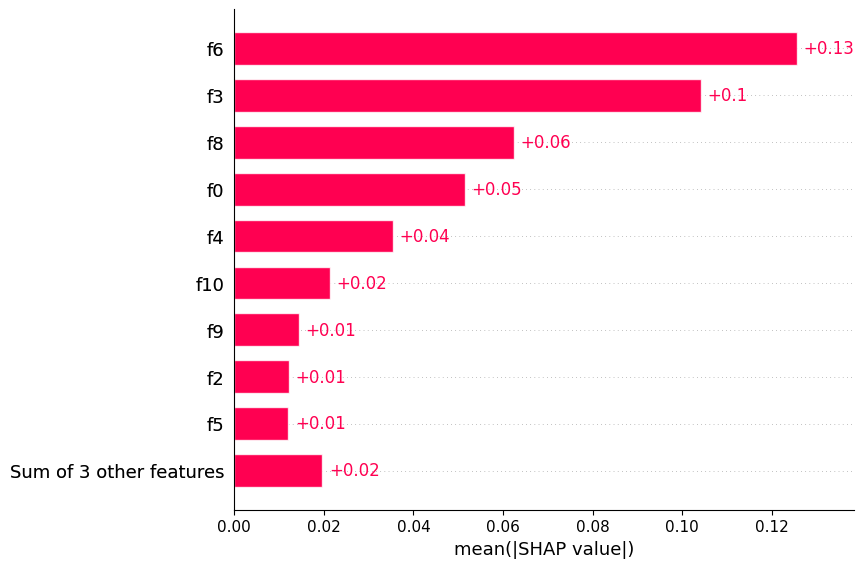

In [ ]:
shap_plot_nn(final_model, X_train, X_test, max_samples=100, feature_names=X_train.columns)

Neural Network Summary:

The F1 score for the model was 0.76, and accuracy was also 0.76, which is acceptable for this type of model, as the factors include behavioural data.

f6, f3 and f8 are still the three most important features, however, their influence is not significantly higher than the remaining factors, with f0 being only slightly lower than f8.